# Project Description
Dataset: 167 Parameters from Astronomy LSST Project Pipeline DMSTACK.

Objective: Estimate the flux of detected objects (galaxies) using various parameters.

Problem type: Regression


# Imports

In [0]:
%%capture
# capture will not print in notebook

import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ### mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    dat_dir = 'drive/My Drive/Colab Notebooks/data/'
    sys.path.append(dat_dir)

    ### Image dir
    img_dir = 'drive/My Drive/Colab Notebooks/images/'
    if not os.path.isdir(img_dir): os.makedirs(img_dir)
    sys.path.append(img_dir)

    ### Output dir
    out_dir = 'drive/My Drive/Colab Notebooks/outputs/'
    if not os.path.isdir(out_dir): os.makedirs(out_dir)
    sys.path.append(out_dir)

    ### Also install my custom module
    module_dir = 'drive/My Drive/Colab Notebooks/Bhishan_Modules/' 
    sys.path.append(module_dir)
    !cd drive/My Drive/Colab Notebooks/Bhishan_Modules/
    !pip install -e bhishan
    !cd -

    ####pip install
    #!pip install pyldavis
    # !pip install catboost
    #!pip install category_encoders # TargetEncoder

    ### hyper parameter tuning
    #!pip install hyperopt
    #!pip install optuna # hyper param opt

    #### model evaluation
    # !pip install shap
    # !pip install eli5
    # !pip install lime
    # !pip install duecredit
    # !pip install forestci # fci.random_forest_error(model_rf, Xtrain,Xtest)
    # !pip install -q dtreeviz # decision tree viz

    #### faster pandas
    # df['x'].swifter.apply(myfunc)
    # df[['x','y']].swifter.apply(myfunc,pos_arg,keyword_arg=mykeyword_arg)
    # !pip install swifter
    
    #### update modules
    !pip install -U scikit-learn # we need restart
    # import sklearn

    #### update pandas profiling
    #### profile = df.profile_report(style={'full_width':True})
    #### profile.to_file(output_file="output.html")
    !pip install -U pandas-profiling # we need restart
    import pandas_profiling


    #### Note: We need to restart kernel to use tqdm
    #!pip install -U tqdm
    # from tqdm.notebook import trange, tqdm
    # tqdm.pandas()
    # out = df['A'].progress_apply(myfunc)
    


    #### == Big Data == ####
    ### Make sure you have spark folder in your google drive and mounted the drive
    # !export SPARK_PATH="drive/My Drive/Colab Notebooks/spark-2.4.3-bin-hadoop2.7"
    # !export PYSPARK_DRIVER_PYTHON="jupyter" 
    # !export PYSPARK_DRIVER_PYTHON_OPTS="notebook" 
    # !pip install pyspark
    # !pip install koalas
    # import pyspark

    #### print
    print('Environment: Google Colaboratory.')

# NOTE: If we update modules in gcolab, we need to restart runtime.

In [2]:
!pip freeze | egrep "pandas|sci"

datascience==0.10.6
pandas==0.25.3
pandas-datareader==0.7.4
pandas-gbq==0.11.0
pandas-profiling==2.3.0
scikit-image==0.15.0
scikit-learn==0.22
scipy==1.3.3
sklearn-pandas==1.8.0


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
plt.style.use('ggplot') # better than sns styles.
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time

# random state
SEED=100
np.random.seed(SEED)

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
pd.options.display.float_format = '{:,.5f}'.format # df.A.value_counts().astype(float)
from pandas.api.types import CategoricalDtype
np.set_printoptions(precision=3)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 200)

import IPython
from IPython.display import display, HTML, Image, Markdown

print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.17.4'), ('pandas', '0.25.3'), ('seaborn', '0.9.0'), ('matplotlib', '3.1.2')]


In [4]:
import scipy
import tqdm
import sklearn
print([(x.__name__,x.__version__) for x in [tqdm,sklearn]])

[('tqdm', '4.28.1'), ('sklearn', '0.22')]


In [0]:
# pickle
import pickle
import joblib # joblib.dump(model,filename)

In [0]:
# scale and split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
# regressors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [0]:
# pipeline
from sklearn.pipeline import Pipeline

In [0]:
# metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [0]:
# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [0]:
df_eval = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

# Useful Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [0]:
def adjustedR2(rsquared,nrows,kcols):
    return rsquared- (kcols-1)/(nrows-kcols) * (1-rsquared)

# Load the Data

In [14]:
ifile = dat_dir + '/flux/processed_0.h5'
df = pd.read_hdf(ifile,key='processed')
print(df.shape)
display(df.info(verbose=False, memory_usage="deep"))

df.head()

(6830, 47)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6830 entries, 6 to 7572
Columns: 47 entries, # calib_detected to base_ClassificationExtendedness_value
dtypes: float32(35), int8(12)
memory usage: 1.0 MB


None

# calib_detected  deblend_deblendedAsPsf  deblend_tooManyPeaks  \
6                  0                       0                     1   
7                  0                       0                     1   
14                 0                       0                     1   
16                 0                       0                     1   
21                 0                       0                     0   

    deblend_rampedTemplate  base_SdssShape_flag  base_SdssShape_flag_shift  \
6                        0                    0                          0   
7                        0                    0                          0   
14                       0                    0                          0   
16                       0                    0                          0   
21                       0                    0                          0   

    ext_shapeHSM_HsmShapeRegauss_flag  \
6                                   1   
7                                   1   
14                                  1   
16                                  1   
21                                  1   

    ext_shapeHSM_HsmShapeRegauss_flag_parent_source  \
6                                                 1   
7                                                 1   
14                                                1   
16                                                1   
21                                                0   

    ext_shapeHSM_HsmShapeRegauss_flag_galsim  base_PixelFlags_flag_edge  \
6                                          0                          1   
7                                          0                          1   
14                                         0                          1   
16                                         0                          1   
21                                         1                          1   

    base_Variance_flag  base_Variance_flag_emptyFootprint  coord_ra  \
6                    0                                  0   0.00190   
7                    0                                  0   0.00180   
14                   0                                  0   0.00060   
16                   0                                  0   0.00250   
21                   0                                  0   0.00100   

    coord_dec  parent  deblend_nChild  base_GaussianCentroid_x  \
6     0.00000 0.00000         3.00000              1,671.94788   
7     0.00000 0.00000         2.00000              1,782.08545   
14    0.00010 0.00000         3.00000              2,952.80908   
16    0.00000 0.00000         3.00000                989.68817   
21    0.00000 0.00000         0.00000              2,529.72803   

    base_GaussianCentroid_y  base_NaiveCentroid_x  base_NaiveCentroid_y  \
6                  28.21710           1,671.06567              27.98990   
7                  32.91540           1,782.01184              32.06270   
14                 53.15800           2,952.04956              53.00670   
16                 26.52890             989.02551              26.02550   
21                 22.63060           2,529.06274              22.03700   

    base_SdssCentroid_x  base_SdssCentroid_y  base_SdssCentroid_xSigma  \
6           1,671.93860             28.14400                   0.08690   
7           1,782.11963             32.81840                   0.08670   
14          2,952.82861             53.12920                   0.04420   
16            989.90411             26.55640                   0.05510   
21          2,529.73438             22.62840                   0.07120   

    base_SdssCentroid_ySigma  base_SdssShape_xx  base_SdssShape_yy  \
6                    0.08770           11.42790           11.29140   
7                    0.09010           11.54210           12.42220   
14                   0.04250           12.85160           11.76920   
16                   0.04490           75.09270           15.56080   
21             

In [15]:
df.columns.to_numpy()

array(['# calib_detected', 'deblend_deblendedAsPsf',
       'deblend_tooManyPeaks', 'deblend_rampedTemplate',
       'base_SdssShape_flag', 'base_SdssShape_flag_shift',
       'ext_shapeHSM_HsmShapeRegauss_flag',
       'ext_shapeHSM_HsmShapeRegauss_flag_parent_source',
       'ext_shapeHSM_HsmShapeRegauss_flag_galsim',
       'base_PixelFlags_flag_edge', 'base_Variance_flag',
       'base_Variance_flag_emptyFootprint', 'coord_ra', 'coord_dec',
       'parent', 'deblend_nChild', 'base_GaussianCentroid_x',
       'base_GaussianCentroid_y', 'base_NaiveCentroid_x',
       'base_NaiveCentroid_y', 'base_SdssCentroid_x',
       'base_SdssCentroid_y', 'base_SdssCentroid_xSigma',
       'base_SdssCentroid_ySigma', 'base_SdssShape_xx',
       'base_SdssShape_yy', 'base_SdssShape_xy', 'base_SdssShape_xxSigma',
       'base_SdssShape_yySigma', 'base_SdssShape_xySigma',
       'base_SdssShape_x', 'base_SdssShape_y', 'base_SdssShape_psf_xx',
       'base_SdssShape_psf_yy', 'base_SdssShape_psf_xy',


# Target Distribution

In [16]:
target = 'base_GaussianFlux_flux'
df[target].describe()

count     6,830.00000
mean     24,742.72656
std      54,128.16797
min         837.23407
25%       3,271.51996
50%       6,683.18408
75%      16,975.29590
max     526,191.12500
Name: base_GaussianFlux_flux, dtype: float64

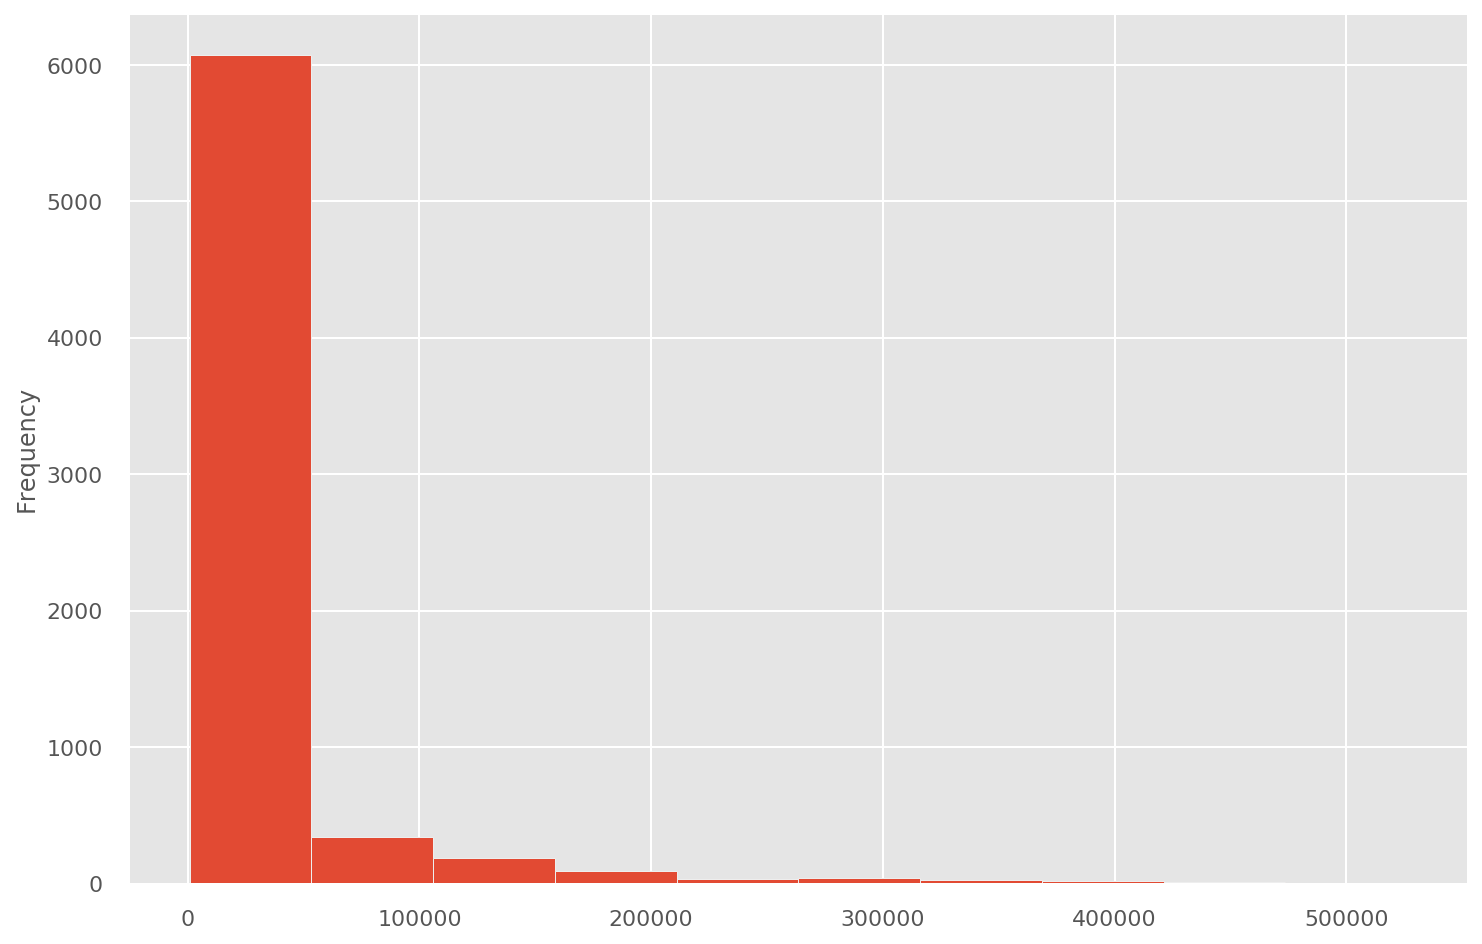

In [17]:
df[target].plot(kind='hist')

# Train-Test split

In [18]:
df_Xtrain, df_Xtest, ser_ytrain, ser_ytest = train_test_split (df.drop(target,axis=1),df[target],
                                                     test_size=0.20,
                                                     random_state=SEED)

ytrain = ser_ytrain.to_numpy().ravel()
ytest = ser_ytest.to_numpy().ravel()

df_Xtrain.shape, ytrain.shape, df_Xtest.shape, ytest.shape

((5464, 46), (5464,), (1366, 46), (1366,))

# Correlations

In [19]:
%%time

import pandas_profiling

df.profile_report(style={'full_width':True}) 

CPU times: user 2min 32s, sys: 14.8 s, total: 2min 47s
Wall time: 2min 9s


![](https://github.com/bhishanpdl/DMstack_obsfile_Clusters/blob/master/Dmstack_Analysis/images/pandas_profile_report.png?raw=True)

# Removing High Correlated Features and Testing with Random Forest

In [20]:
%%time

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=SEED,n_jobs=-1)

model.fit(df_Xtrain,ytrain)
ypreds = model.predict(df_Xtest)

r2 = sklearn.metrics.r2_score(ytest,ypreds)

print(round(r2,6))

0.995963
CPU times: user 19.6 s, sys: 0 ns, total: 19.6 s
Wall time: 10.1 s


In [21]:
df_Xtrain.columns

Index(['# calib_detected', 'deblend_deblendedAsPsf', 'deblend_tooManyPeaks',
       'deblend_rampedTemplate', 'base_SdssShape_flag',
       'base_SdssShape_flag_shift', 'ext_shapeHSM_HsmShapeRegauss_flag',
       'ext_shapeHSM_HsmShapeRegauss_flag_parent_source',
       'ext_shapeHSM_HsmShapeRegauss_flag_galsim', 'base_PixelFlags_flag_edge',
       'base_Variance_flag', 'base_Variance_flag_emptyFootprint', 'coord_ra',
       'coord_dec', 'parent', 'deblend_nChild', 'base_GaussianCentroid_x',
       'base_GaussianCentroid_y', 'base_NaiveCentroid_x',
       'base_NaiveCentroid_y', 'base_SdssCentroid_x', 'base_SdssCentroid_y',
       'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma',
       'base_SdssShape_xx', 'base_SdssShape_yy', 'base_SdssShape_xy',
       'base_SdssShape_xxSigma', 'base_SdssShape_yySigma',
       'base_SdssShape_xySigma', 'base_SdssShape_x', 'base_SdssShape_y',
       'base_SdssShape_psf_xx', 'base_SdssShape_psf_yy',
       'base_SdssShape_psf_xy', 'ext_shapeHSM_

In [22]:
cols_drop = ['base_GaussianCentroid_y',
             'base_NaiveCentroid_x','base_NaiveCentroid_y',
             'base_SdssCentroid_x','base_SdssCentroid_y',
             'base_SdssCentroid_ySigma',
             'base_SdssShape_psf_xy',
             'base_SdssShape_yySigma',
             'base_Variance_flag_emptyFootprint']

cols_keep = df_Xtrain.columns.drop(cols_drop).to_list()
cols_keep

['# calib_detected',
 'deblend_deblendedAsPsf',
 'deblend_tooManyPeaks',
 'deblend_rampedTemplate',
 'base_SdssShape_flag',
 'base_SdssShape_flag_shift',
 'ext_shapeHSM_HsmShapeRegauss_flag',
 'ext_shapeHSM_HsmShapeRegauss_flag_parent_source',
 'ext_shapeHSM_HsmShapeRegauss_flag_galsim',
 'base_PixelFlags_flag_edge',
 'base_Variance_flag',
 'coord_ra',
 'coord_dec',
 'parent',
 'deblend_nChild',
 'base_GaussianCentroid_x',
 'base_SdssCentroid_xSigma',
 'base_SdssShape_xx',
 'base_SdssShape_yy',
 'base_SdssShape_xy',
 'base_SdssShape_xxSigma',
 'base_SdssShape_xySigma',
 'base_SdssShape_x',
 'base_SdssShape_y',
 'base_SdssShape_psf_xx',
 'base_SdssShape_psf_yy',
 'ext_shapeHSM_HsmPsfMoments_x',
 'ext_shapeHSM_HsmPsfMoments_y',
 'ext_shapeHSM_HsmPsfMoments_xx',
 'ext_shapeHSM_HsmPsfMoments_yy',
 'ext_shapeHSM_HsmPsfMoments_xy',
 'ext_shapeHSM_HsmSourceMoments_x',
 'ext_shapeHSM_HsmSourceMoments_y',
 'ext_shapeHSM_HsmSourceMoments_xx',
 'ext_shapeHSM_HsmSourceMoments_yy',
 'ext_shapeHSM_H

In [23]:
%%time
df[cols_keep].profile_report(style={'full_width':True}) 

CPU times: user 2min 2s, sys: 13.1 s, total: 2min 15s
Wall time: 1min 43s


In [24]:
%%time


from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=SEED,n_jobs=-1)

Xtr = df_Xtrain[cols_keep]
Xtx = df_Xtest[cols_keep]

model.fit(Xtr,ytrain)
ypreds = model.predict(Xtx)

r2 = sklearn.metrics.r2_score(ytest,ypreds)

"""
baseline:  0.995963
cols_keep: 0.996147 I will keep these and will again look at random forest feat imp
2 more   : 0.995895
"""

print(round(r2,6))

0.996147
CPU times: user 14.8 s, sys: 0 ns, total: 14.8 s
Wall time: 8.34 s


# Feature Importances

Time taken: 0 hr 0 min 30 secs


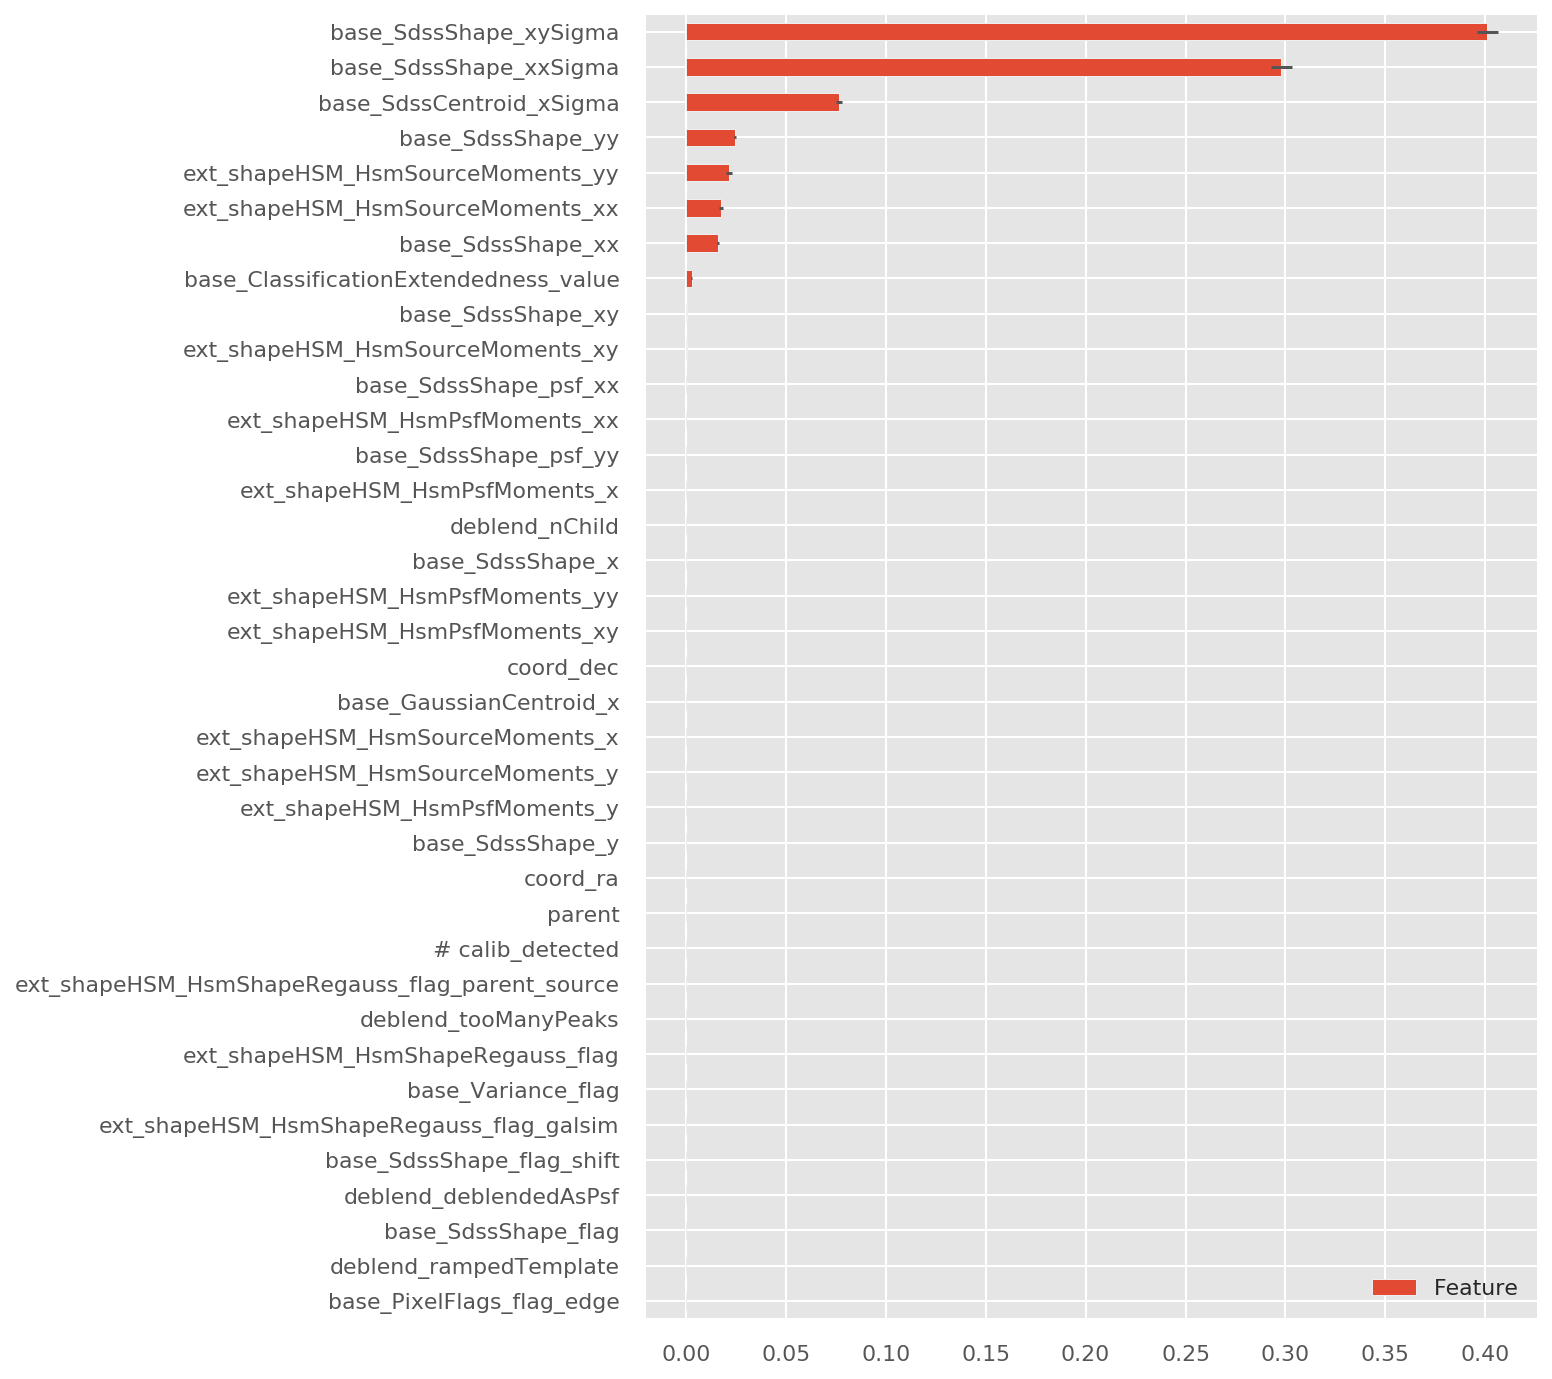

In [25]:
time_start = time.time()

# permutation importance needs sklearn > 0.22 
# this is also available in eli5
from sklearn.inspection import permutation_importance

result = permutation_importance(model, df_Xtrain[cols_keep],
                                ytrain, n_repeats=5,
                                random_state=SEED, n_jobs=-1)

time_taken = time.time() - time_start
h,m = divmod(time_taken,60*60)
print('Time taken: {:.0f} hr {:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

df_imp = pd.DataFrame({'Feature': result.importances_mean,
                       'std': result.importances_std
                     },
                      index=cols_keep)


df_imp.sort_values('Feature').plot(kind='barh',y='Feature',
                                   xerr='std',figsize=(8,12))

In [26]:
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
df_imp['Feature'].sort_values().to_numpy()

array([-0.000000, -0.000000,  0.000000,  0.000000,  0.000000,  0.000001,
        0.000003,  0.000003,  0.000007,  0.000007,  0.000018,  0.000042,
        0.000056,  0.000058,  0.000073,  0.000081,  0.000082,  0.000090,
        0.000092,  0.000094,  0.000094,  0.000096,  0.000110,  0.000115,
        0.000137,  0.000167,  0.000187,  0.000340,  0.000416,  0.002870,
        0.016191,  0.017693,  0.021426,  0.024396,  0.076524,  0.297916,
        0.400951])

In [27]:
df_imp.query('Feature > 0.00010')

Feature     std
deblend_nChild                         0.00011 0.00001
base_SdssCentroid_xSigma               0.07652 0.00145
base_SdssShape_xx                      0.01619 0.00056
base_SdssShape_yy                      0.02440 0.00054
base_SdssShape_xy                      0.00042 0.00003
base_SdssShape_xxSigma                 0.29792 0.00537
base_SdssShape_xySigma                 0.40095 0.00523
base_SdssShape_psf_xx                  0.00019 0.00004
base_SdssShape_psf_yy                  0.00014 0.00002
ext_shapeHSM_HsmPsfMoments_x           0.00011 0.00003
ext_shapeHSM_HsmPsfMoments_xx          0.00017 0.00003
ext_shapeHSM_HsmSourceMoments_xx       0.01769 0.00103
ext_shapeHSM_HsmSourceMoments_yy       0.02143 0.00147
ext_shapeHSM_HsmSourceMoments_xy       0.00034 0.00002
base_ClassificationExtendedness_value  0.00287 0.00017

In [28]:
cols_keep2 = df_imp.query('Feature > 0.0001').index.to_list()
cols_keep2

['deblend_nChild',
 'base_SdssCentroid_xSigma',
 'base_SdssShape_xx',
 'base_SdssShape_yy',
 'base_SdssShape_xy',
 'base_SdssShape_xxSigma',
 'base_SdssShape_xySigma',
 'base_SdssShape_psf_xx',
 'base_SdssShape_psf_yy',
 'ext_shapeHSM_HsmPsfMoments_x',
 'ext_shapeHSM_HsmPsfMoments_xx',
 'ext_shapeHSM_HsmSourceMoments_xx',
 'ext_shapeHSM_HsmSourceMoments_yy',
 'ext_shapeHSM_HsmSourceMoments_xy',
 'base_ClassificationExtendedness_value']

In [29]:
%%time

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=SEED,n_jobs=-1)

THRESHOLD = 0.0001
cols_keep = df_imp.query('Feature > @THRESHOLD').index.to_list()
Xtr = df_Xtrain[cols_keep]
Xtx = df_Xtest[cols_keep]

model.fit(Xtr,ytrain)
ypreds = model.predict(Xtx)

r2 = sklearn.metrics.r2_score(ytest,ypreds)

"""
baseline:     0.995963
cols_keep:    0.996147 I will keep these and will again look at random forest feat imp
2 more   :    0.995895
cols_keep2:   0.996379
"""

print(round(r2,6))

0.996379
CPU times: user 8.5 s, sys: 172 µs, total: 8.51 s
Wall time: 4.48 s


In [30]:
%%time
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=SEED,n_jobs=-1)

THRESHOLD = 0.00015
cols_keep = df_imp.query('Feature > @THRESHOLD').index.to_list()
Xtr = df_Xtrain[cols_keep]
Xtx = df_Xtest[cols_keep]

model.fit(Xtr,ytrain)
ypreds = model.predict(Xtx)

r2 = sklearn.metrics.r2_score(ytest,ypreds)


"""
baseline          ==> 0.995963
threshold 0.00015 ==> 0.996569
"""

print(round(r2,6))

0.996569
CPU times: user 7.33 s, sys: 17.2 ms, total: 7.34 s
Wall time: 3.87 s


# Save Clean Data

In [31]:
THRESHOLD = 0.00015
cols_keep = df_imp.query('Feature > @THRESHOLD').index.to_list()
cols_keep

['base_SdssCentroid_xSigma',
 'base_SdssShape_xx',
 'base_SdssShape_yy',
 'base_SdssShape_xy',
 'base_SdssShape_xxSigma',
 'base_SdssShape_xySigma',
 'base_SdssShape_psf_xx',
 'ext_shapeHSM_HsmPsfMoments_xx',
 'ext_shapeHSM_HsmSourceMoments_xx',
 'ext_shapeHSM_HsmSourceMoments_yy',
 'ext_shapeHSM_HsmSourceMoments_xy',
 'base_ClassificationExtendedness_value']

In [0]:
df = df[cols_keep]
ofile = dat_dir + '/flux/processed_1.csv'

df.to_csv(ofile)